In [1]:
from __future__ import print_function

import os
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
csv_path = os.environ['CSV_PATH']

# load the data
training_df = pd.read_csv(csv_path)

# randomize the data
training_df = training_df.reindex(np.random.permutation(training_df.index))

print("training_df:")
# examine the data
print(training_df.describe())

training_df:
       temperature_336  windSpeed_336  humidity_336  temperature_335  \
count           1570.0         1569.0        1567.0           1570.0   
mean              61.2            1.7           0.6             59.9   
std                9.7            2.0           0.2              9.5   
min               27.8            0.0           0.1             26.3   
25%               54.8            0.5           0.4             53.9   
50%               61.2            1.1           0.6             59.9   
75%               67.7            2.2           0.8             66.5   
max               96.5           20.0           1.0             94.8   

       windSpeed_335  humidity_335  temperature_334  windSpeed_334  \
count         1570.0        1568.0           1570.0         1567.0   
mean             1.6           0.6             58.9            1.5   
std              2.0           0.2              9.3            1.9   
min              0.0           0.1             25.7       

In [3]:

def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """
    Trains a linear regression model of one feature

    Args:
        features: pandas DataFrame of features
        targets: pandas DataFrame of targets
        batch_size: size of batches to be passed to the model
        shuffle: whether or not to shuffle the data
        num_epochs: number of epochs for which data should be repeated (None=repeat indefinitely)

    Returns:
        Tuple of (features, labels) for next data batch

    """

    # Convert pandas data into a dict of np arrays
    features = {key: np.array(value) for key, value in dict(features).items()}

    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features, targets))  # 2gb limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)

    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()

    return features, labels


In [31]:
def train_model(learning_rate, steps, periods, batch_size, input_feature, training_df):
    """Trains a linear regression model of one feature.

    Args:
        learning_rate: A `float`, the learning rate
        steps: A non-zero `int`, the total number of training steps. 
            A training step consists of a forward and backward pass using 
            a single batch.
        periods: A non-zero `int`, the number of training periods
        batch_size: A non-zero `int`, the batch size.
        input_feature: A `string` specifying a column from `training_df` to 
            use as input feature.
        training_df: A pandas DataFrame
    """
    steps_per_period = steps/periods

    # create feature columns
    my_feature = input_feature
    my_feature_data = training_df[[my_feature]]
    my_label = TARGET_COLUMN
    targets = training_df[my_label]

    # create input functions
    def training_input_fn(): return my_input_fn(
        my_feature_data, targets, batch_size=batch_size)

    def prediction_input_fn(): return my_input_fn(
        my_feature_data, targets, num_epochs=1, shuffle=False)

    # create a linear regressor object
    my_optimizer = tf.train.GradientDescentOptimizer(
        learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(
        my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )

    # set up to plot the state of our model's line each period
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    # sample = training_df.sample(n=300)
    sample = training_df
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

    # train the model, but do so inside a loop so that we can periodically asses loss metrics
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    for period in range(0, periods):
        # train the model, starting from the prior state
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # take a break and compute predictions
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0]
                                for item in predictions])

        # compute loss
        root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(predictions, targets))

        # occassionally print the current loss
        print("  period %02d : %0.2f" % (period, root_mean_squared_error))

        # add the loss metrics from this period to our list
        root_mean_squared_errors.append(root_mean_squared_error)
        # finally, track the weights and biases over time
        # apply some math to ensure that the data and line are plotted neatly
        y_extents = np.array([0, sample[my_label].max()])

        weight = linear_regressor.get_variable_value(
            'linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value(
            'linear/linear_model/bias_weights')

        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,
                                          sample[my_feature].max()),
                               sample[my_feature].min())

        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period])
        

    print("Model training finished")
    
    weight = linear_regressor.get_variable_value(
            'linear/linear_model/%s/weights' % input_feature)[0]
    print("weight: ", weight)
    
    bias = linear_regressor.get_variable_value(
            'linear/linear_model/bias_weights')
    
    print("bias: ", bias)
    
    # output a graph of loss metrics over periods
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)

    plt.show()

    # output a table with calibration data
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())



    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)


         Size      Costs
count   165.0      165.0
mean   2877.1  1851511.5
std    7114.4  3580720.3
min       3.0        1.0
25%      68.0   100000.0
50%     410.0   435819.0
75%    1845.0  1680000.0
max   61690.0 24976052.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023CAB134470>]],
      dtype=object)

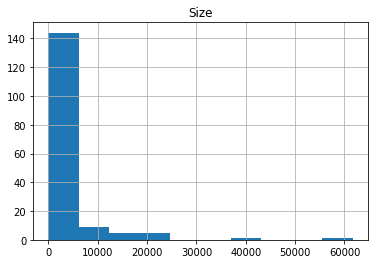

In [68]:
# in tf, we indicate a feature's data type using a feature column

INPUT_COLUMN = "Size"
TARGET_COLUMN = "Costs"
LEARNING_RATE = 0.2
STEPS = 500
PERIODS = 1
# BATCH_SIZE = 1000

feature_columns = [tf.feature_column.numeric_column(INPUT_COLUMN)]

# make a copy of the full training data
source_df = training_df.copy()

TRAINING_DF = pd.DataFrame()
TRAINING_DF[INPUT_COLUMN] = source_df[INPUT_COLUMN]
TRAINING_DF[TARGET_COLUMN] = source_df[TARGET_COLUMN]

# drop all rows containing a NaN value in either the input feature or target column
TRAINING_DF = TRAINING_DF.dropna(subset=[INPUT_COLUMN, TARGET_COLUMN])
# TRAINING_DF = TRAINING_DF.query('Size<30000')

BATCH_SIZE = len(TRAINING_DF.index) # batch gradient descent

print(TRAINING_DF.describe())
TRAINING_DF.hist(INPUT_COLUMN)

Training model...
RMSE (on training data):
  period 00 : 2105112.62
Model training finished
weight:  [448.00665]
bias:  [1.197636]


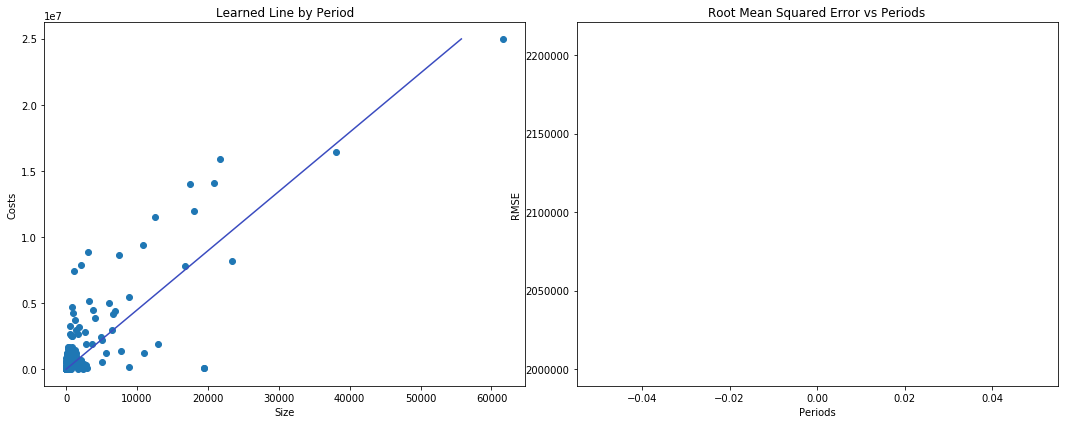

,predictions,targets
count,165.0,67.0
mean,1288953.0,2209583.1
std,3187319.8,4458289.4
min,1345.2,1.0
25%,30465.7,105000.0
50%,183683.9,532704.0
75%,826573.4,2319080.0
max,27637532.0,24976052.0


Final RMSE (on training data): 2105112.62


In [69]:
train_model(
    learning_rate=LEARNING_RATE,
    steps=STEPS,
    periods=PERIODS,
    batch_size=BATCH_SIZE,
    input_feature=INPUT_COLUMN,
    training_df=TRAINING_DF
)